In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
#embedding lookup table
C = torch.randn((27, 2))
C[0]

tensor([0.6024, 0.1613])

In [9]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
h

tensor([[ 0.6194, -0.9935, -0.3801,  ...,  0.9623,  0.9577, -0.6969],
        [ 0.2976, -0.9985,  0.1248,  ...,  0.6229,  0.9529, -0.8862],
        [ 0.4467, -0.9942, -0.4144,  ..., -0.5249,  0.8659, -0.7305],
        ...,
        [ 0.9078,  0.1513, -0.9998,  ...,  0.9903,  0.9531,  0.9709],
        [ 0.4081, -0.9979,  0.7706,  ...,  0.9159,  0.9965, -0.7136],
        [ 0.7665, -0.9992, -0.9991,  ..., -0.1701,  0.9751,  0.7187]])

In [13]:
h.shape

torch.Size([228146, 100])

In [14]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()

In [18]:
prob = counts / counts.sum(1, keepdims=True)

In [19]:
#indexing throught the probabilities with labels 
Y.shape

torch.Size([228146])

In [20]:
#negative log likelihood loss 
#loss = -prob[torch.arange(32), Y].log().mean()
#loss

In [21]:
# ------------ now made respectable :) ---------------
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

In [279]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
context_length=10
neurons=220
C = torch.randn((27, context_length), generator=g)
W1 = torch.randn((context_length*3, neurons), generator=g)
b1 = torch.randn(neurons, generator=g)
W2 = torch.randn((neurons, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

learning_rate=0.01
learning_rate_decay=0.01


In [280]:
sum(p.nelement() for p in parameters) # number of parameters in total

8997

In [281]:
for p in parameters:
  p.requires_grad = True

In [282]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [283]:
lri = []
lossi = []
stepi = []

BATCH_SIZE=32

In [284]:
for i in range(20000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
  

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, context_length*3) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  current_learning_rate=learning_rate*(1/(1+learning_rate_decay*i))
  for p in parameters:
    p.data += -current_learning_rate * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

22.038877487182617
25.6046199798584
23.167604446411133
23.01619529724121
23.882068634033203
23.98323631286621
27.87447738647461
24.873661041259766
22.603437423706055
23.132766723632812
23.527053833007812
23.329933166503906
18.54591178894043
20.114839553833008
21.297107696533203
25.179195404052734
27.040603637695312
23.57572364807129
25.465253829956055
22.118318557739258
22.833547592163086
22.290367126464844
24.634361267089844
22.977745056152344
20.874603271484375
21.60075569152832
23.150590896606445
18.700490951538086
24.250364303588867
23.39264488220215
19.24814224243164
22.670053482055664
19.958934783935547
18.878915786743164
20.2005672454834
23.237131118774414
22.321287155151367
19.74757194519043
22.389080047607422
18.588146209716797
18.557964324951172
20.20372772216797
21.08707046508789
18.507701873779297
24.77031898498535
22.835607528686523
22.24728012084961
24.022571563720703
20.951435089111328
21.05187225341797
19.41925048828125
19.42806625366211
20.327301025390625
20.6401195526

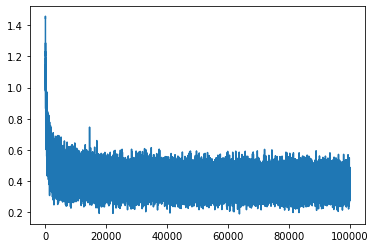

In [245]:
plt.plot(stepi, lossi)

In [246]:
#evaluate the train 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, context_length*3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4163, grad_fn=<NllLossBackward0>)

In [247]:
#evaluate the validation set  
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, context_length*3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4339, grad_fn=<NllLossBackward0>)

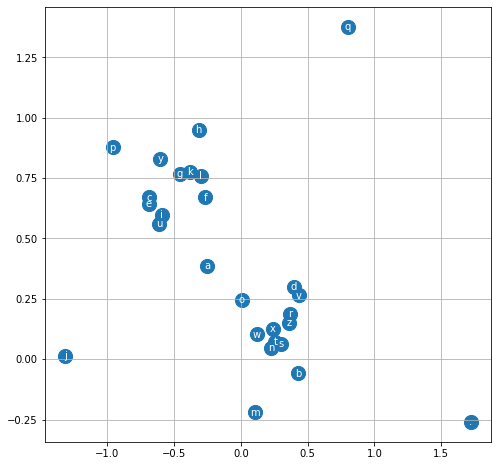

In [90]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [33]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [34]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amille.
khlin.
shithty.
salaysa.
jazonte.
ameryst.
kaeli.
nelenia.
chaiivin.
lege.
dham.
elin.
quijons.
lilea.
jadii.
wavero.
dearixi.
faysenilsan.
emaedo.
